<a href="https://colab.research.google.com/github/Ajjme/Climate_Response_Modeling/blob/main/Earth_Heat_Equil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def ode4u(odefun, time, x0, u=None, c=None):
    """
    Solve a system of nonhomogeneous ODEs using the 4th-order Runge-Kutta method.
    (it depends on not just time and state but also external inputs (u) and constanstant (c))

    Parameters:
        odefun : function (t, x, u, c) -> (dxdt, y)
                 returns state derivative and output as arrays
        time   : time values at which the solution is computed.
                 p-dimensional array
        x0     : n-dimensional array, state at time[0].
        u      : (m x p) dimensional array
                 optional input sampled at each time step.
        c      : optional constants passed to odefun.

    Returns:
        time   : ndarray, shape (1, p)
        x_sol  : ndarray, shape (n, p)
        x_drv  : ndarray, shape (n, p)
        y_sol  : ndarray, shape (m, p)
    """

    time   = np.asarray(time)
    x0     = np.asarray(x0).flatten()
    points = len(time) # the total number of time steps

    # create defaults if not provided
    if c is None:
        c = 0
    if u is None:
        u = np.zeros((1, points))
    else:
        u = np.asarray(u)

    # verify inputs recieved are in 2D array shape
    if u.ndim == 1:
        u = u[np.newaxis, :]

    if u.shape[1] < points:
        pad_width = points - u.shape[1]
        u = np.pad(u, ((0, 0), (0, pad_width)), mode='constant')

    # state derivitives and outputs at time[0]
    dxdt0, y0 = odefun(time[0], x0, u[:, 0], c)

    n = x0.size                 # number of states
    m = np.asarray(y0).size     # nuber of outputs

    # allocate memory
    x_sol = np.ones([n, points])*np.nan
    x_drv = np.ones([n, points])*np.nan
    y_sol = np.ones([m, points])*np.nan

    x_sol[:, 0] = x0    # states
    x_drv[:, 0] = dxdt0 # state derivitives
    y_sol[:, 0] = y0    # outputs

    for p in range(points - 1):  # time stepping loop and main integration
        t = time[p]
        dt = time[p + 1] - t
        dt2 = dt / 2.0

        u_mid = (u[:, p] + u[:, p + 1]) / 2.0

        # intermediate dervitives
        dxdt1, _ = odefun(t + dt2, x0 + dxdt0 * dt2, u_mid, c)
        dxdt2, _ = odefun(t + dt2, x0 + dxdt1 * dt2, u_mid, c)
        dxdt3, _ = odefun(t + dt,  x0 + dxdt2 * dt, u[:, p + 1], c)

        # state update using the intermediate derivities
        x0 = x0 + ( dxdt0 + 2 * (dxdt1 + dxdt2) + dxdt3 ) * dt / 6.0

        # state derivitives and outputs at start of time (p+1)
        dxdt0, y0 = odefun(time[p + 1], x0, u[:, p + 1], c)

        # save states (solution), state derivitives, and outputs
        x_sol[:, p+1] = x0    # state
        x_drv[:, p+1] = dxdt1 # state derivitives
        y_sol[:, p+1] = y0    # output

        # safety - incase NaN or Inf
#       if not np.all(np.abs(x0) > 1e12):
        if not np.all(np.isfinite(x0)):
            break

    return time, x_sol, x_drv, y_sol

In [3]:
''' ... from console
import importlib , earth_heat_equil
importlib.reload(earth_heat_equil)     # to reload edits
'''
class c:
    pi  = np.pi
    Rs  =    6.9570e08        # radius of sun, meters
    D   =    1.4960e11        # sun - to - earth distance, meters
    Re  =    6.3567523e6      # radius of earth, meters
    Ts  = 5777                # sun temperature, deg K
    c   =  299.792458e6       # speed of light  m/s
    h   =    6.62607015e-34   # Planck's constant  J / Hz
    k   =    1.380649e-23     # Boltzmann's constant J / deg K
    sbc =    5.670367e-8;     # Stefan-Boltzman constant  ... W/sq.m/deg K^4
    aa  =    0.30             # albedo 0.3 - 0.4 fraction of solar reflected
    ee  =    0.78             # emissivity without atmosphere or GHG

def run():

# ------------------------------------------- constants
    # the Stefan-Boltzman constant depends on other constants ... k, h, and c
    sbc = ( 2 * c.pi**5 * c.k**4 ) / ( 15 * c.h**3 * c.c**2 );

    # solar constant
    # power over the circular section of the earth = 1361.0  W / sq.m "S_o"
    So = c.sbc*c.Ts**4 * 4*c.pi*c.Rs**2 / ( 4*c.pi*c.D**2 )

    # temperature of the earth's surface ... 255.03 deg K with aa=0.3 and ee=0
    To = ( So/4 * (1-c.aa)/c.sbc )**0.25               # w/o  atmosphere ee=0
    To = ( So/4 * (1-c.aa)/c.sbc / (1-c.ee/2) )**0.25  # with atmosphere

    # temperature of atmosphere ... 255.03 deg K with an albedo aa=0.3
    Ta = To / 2**0.25

    # Plank's Law black-body electromagnetic radiation spectrum  --------------

    l = np.linspace( 0.1 , 100 , 2000 )*1e-6 # light wave length m

    # Planck's Law
    # spectrum of solar radiated energy at the solar surface   W/sq.m
    Bs = 2*c.pi*c.h*c.c**2 / l**5 / ( np.exp((c.h*c.c)/(l*c.k*c.Ts)) - 1 )
    # spectrum of solar radiated energy reaching the earth W/sq.m
    Bs = Bs * 4*c.pi*c.Rs**2 / (4*c.pi*c.D**2) * (c.pi*c.Re**2) / (4*c.pi*c.Re**2)

    # Planck's Law
    # spectrum of radiated energy at the earth's surface   W/sq.m
    Bo = 2*c.pi*c.h*c.c**2 / l**5 / ( np.exp((c.h*c.c)/(l*c.k*To)) - 1 )
    We = c.sbc * To**4

    # radiative "forcing"  ...  feedback  W/sq.m
    RF = c.ee * c.sbc * ( Ta**4 - To**4 )

    intBS = np.trapz(Bs,l)            # 1366 W / sq.m
    intBE = np.trapz(Bo,l)            #  881 W / sq.m  with aa = 0.35

    print('intBS %7.2f intBE %7.2f  We %7.2f  RF %7.2f', intBS,intBE,We,RF)

# ---------------------------------------------------------- Plots

    plt.ion()                    # plot interactive mode: on
    plt.rcParams['font.size'] = 14;

    clrR = 'tab:red'
    clrB = 'tab:blue'

    # log wave-length axis
    f1 = plt.figure(1)
    plt.clf()
    ax1 = f1.subplots()
    ax1.semilogx(l*1e6,Bs/1e6, color=clrR, label=r"Sun @ %4.0f K" % c.Ts )
    ax1.set_xlabel('wave length of light, \u03BB, \u03BCm, (microns)')
    ax1.set_ylabel('solar spectral intensity, W/sq.m / \u03BCm', color=clrR)
    ax1.tick_params(axis='y', labelcolor=clrR)
    plt.text(0.40,100,'v', color='tab:purple')
    plt.text(0.45,100,'b', color='tab:blue')
    plt.text(0.50,100,'g', color='tab:green')
    plt.text(0.60,100,'y', color='tab:olive')
    plt.text(0.70,100,'o', color='tab:orange')
    plt.text(0.80,100,'r', color='tab:red')
    plt.text(6,100,'infra-red')

    ax2 = ax1.twinx()
    ax2.semilogx(l*1e6,Bo/1e6, color=clrB, label=r"Earth @ %4.0f K" % To )
    ax2.set_ylabel('earth spectral intensity, W/sq.m/ \u03BCm', color=clrB)
    ax2.tick_params(axis='y', labelcolor=clrB)
    plt.title(r"$\alpha$=%4.2f ,  $\epsilon$=%4.2f , $T_o$=%5.1f$^o$C , $T_a$=%5.1f$^o$C" % (c.aa,c.ee,To-273,Ta-273)  )

    # linear wave-length axis
    f2 = plt.figure(2)
    plt.clf()
    ax1 = f2.subplots()
    l1 = ax1.plot(l*1e6,Bs/1e6, color=clrR, label=r"Sun   @ %4.0f K" % c.Ts )
    ax1.set_xlabel('wave length of light, \u03BB, \u03BCm, (microns)')
    ax1.set_ylabel('solar spectral intensity, W/sq.m / \u03BCm', color=clrR)
    ax1.tick_params(axis='y', labelcolor=clrR)

    ax2 = ax1.twinx()
    l2 = ax2.plot(l*1e6,Bo/1e6, color=clrB, label=r"Earth @ %4.0f K" % To )
    ax2.set_ylabel('earth spectral intensity, W/sq.m/ \u03BCm', color=clrB)
    ax2.tick_params(axis='y', labelcolor=clrB)
    plt.title(r"$\alpha$=%4.2f ,  $\epsilon$=%4.2f , $T_o$=%5.1f$^o$C , $T_a$=%5.1f$^o$C" % (c.aa,c.ee,To-273,Ta-273)  )
    f2.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

    plt.show()


/tmp/ipython-input-495585511.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  intBS = np.trapz(Bs,l)            # 1366 W / sq.m
/tmp/ipython-input-495585511.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  intBE = np.trapz(Bo,l)            #  881 W / sq.m  with aa = 0.35


intBS %7.2f intBE %7.2f  We %7.2f  RF %7.2f 341.46132111101383 389.7786125171456 391.8408157394486 -152.81791813838493


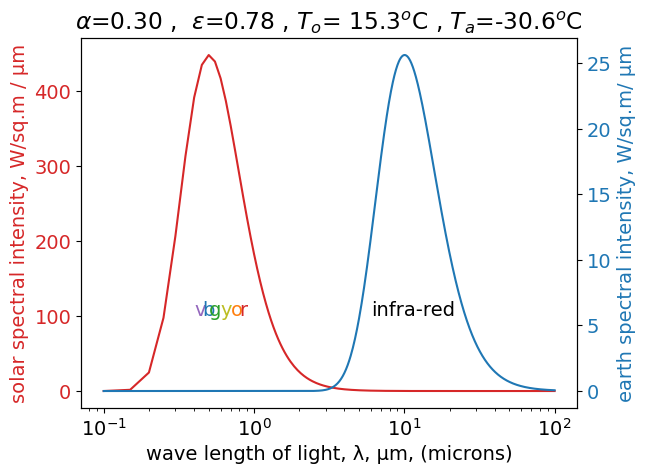

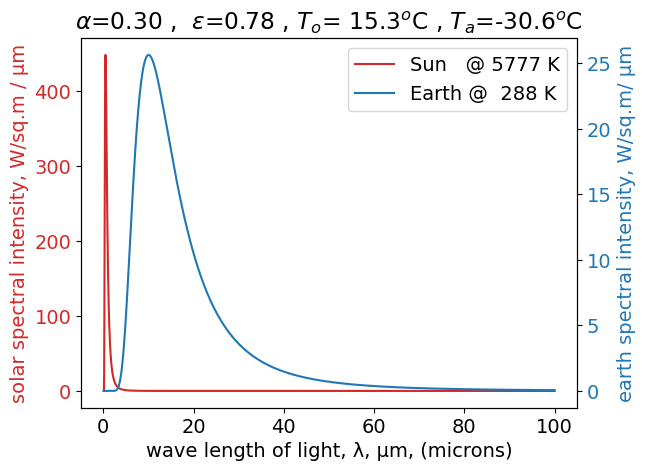

In [4]:
run()